# import library

In [1]:
!pip install keras-tuner --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.8 MB/s eta 0:00:00


In [2]:
# Standard library imports
import os
import sys
from collections import Counter
from tempfile import NamedTemporaryFile
from urllib.parse import urlparse, unquote
from urllib.request import urlopen
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

# Third-party imports for data manipulation and analysis
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

# Third-party imports for natural language processing
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.layers import TextVectorization

# Third-party imports for deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks, metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import keras_tuner
from kerastuner import HyperModel
from kerastuner.tuners import Hyperband
from tensorflow.keras.metrics import Precision, Recall

# Third-party imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

<ipython-input-2-cc0a619c1a66>:40: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import HyperModel


# load data

In [3]:
# Load URL dataset
url_df = pd.read_excel('/content/drive/MyDrive/Bootcamp NLP Batch 3 Indonesia AI/Final Project/look-before-you-leap/URL.xlsx')

# Load HTML dataset
html_df = pd.read_excel('/content/drive/MyDrive/Bootcamp NLP Batch 3 Indonesia AI/Final Project/look-before-you-leap/html.xlsx')

# menampilkan dataset
print("URL Dataset:")
print(url_df.head())
print("\nHTML Dataset:")
print(html_df.head())

URL Dataset:
  Category                                               Data
0     spam  logtelstra2021.ddnsking.com/0dfa1b53b835500696...
1     spam  dvsber.ru/modules/mod_ariimageslidersa/KRENK3N...
2     spam  kimsinc564.000webhostapp.com/notification.php?...
3     spam                                     benjim.com/all
4     spam                    www.m.micesrunescape.com-we.ru/

HTML Dataset:
  Category                                               Data
0     spam  <!DOCTYPE html>', '', '<html>', '<head>', '<me...
1     spam  <!DOCTYPE html><html dir="ltr" lang="en"><head...
2     spam  <!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 T...
3     spam  <meta content="1; URL=\'https://segurancaitauo...
4     spam  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.01//...


#EDA

##info dasar data

In [4]:
url_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45373 entries, 0 to 45372
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  45373 non-null  object
 1   Data      45373 non-null  object
dtypes: object(2)
memory usage: 709.1+ KB


In [5]:
html_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45373 entries, 0 to 45372
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  45373 non-null  object
 1   Data      45373 non-null  object
dtypes: object(2)
memory usage: 709.1+ KB


In [6]:
print(f'Banyak baris dataset url {url_df.shape[0]} dan kolom {url_df.shape[1]}')
print(f'Banyak baris dataset html {html_df.shape[0]} dan kolom {html_df.shape[1]}')

Banyak baris dataset url 45373 dan kolom 2
Banyak baris dataset html 45373 dan kolom 2


# missing value cek

In [7]:
print("\nMissing Values URL Dataset:")
print(url_df.isnull().sum())
print("\nMissing Values HTML Dataset:")
print(html_df.isnull().sum())


Missing Values URL Dataset:
Category    0
Data        0
dtype: int64

Missing Values HTML Dataset:
Category    0
Data        0
dtype: int64


# sebaran nilai kategori

In [8]:
# Value Counts
print("\nSebaran kategori di URL Dataset:")
print(url_df['Category'].value_counts())
print("\nSebaran kategori di HTML Dataset:")
print(html_df['Category'].value_counts())


Sebaran kategori di URL Dataset:
ham     22687
spam    22686
Name: Category, dtype: int64

Sebaran kategori di HTML Dataset:
ham     22687
spam    22686
Name: Category, dtype: int64


# visualisasi sebaran nilai kategori

<ipython-input-9-e131a6af5b1f>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=html_df, palette=color_palette, ax=axes[0])
<ipython-input-9-e131a6af5b1f>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Category', data=url_df, palette=color_palette, ax=axes[1])


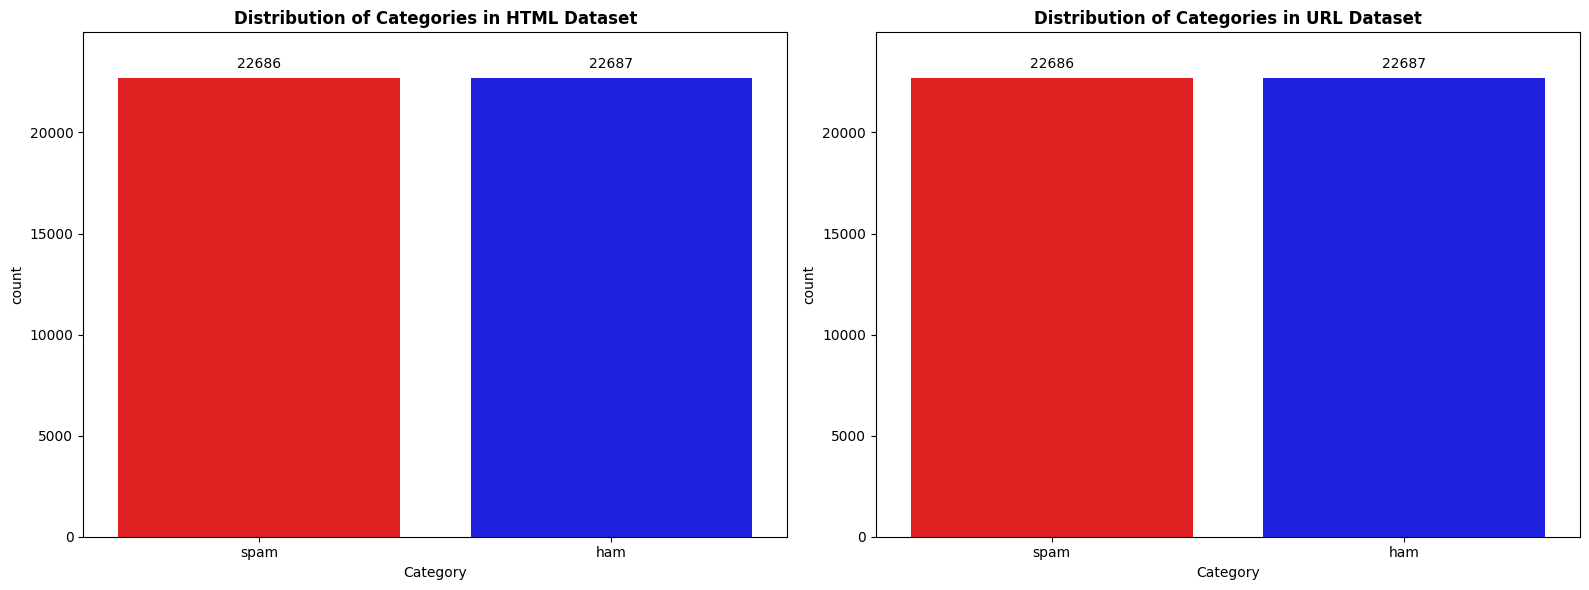

In [9]:
# Set up the figure and axes for subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Customized color palette
color_palette = ['red', 'blue']

# Plot for HTML dataset
sns.countplot(x='Category', data=html_df, palette=color_palette, ax=axes[0])
axes[0].set_title('Distribution of Categories in HTML Dataset', fontweight='bold')

# Add exact values on top of the bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

axes[0].set_ylim(0, max([p.get_height() for p in axes[0].patches])*1.1)

# Plot for URL dataset
sns.countplot(x='Category', data=url_df, palette=color_palette, ax=axes[1])
axes[1].set_title('Distribution of Categories in URL Dataset', fontweight='bold')

# Add exact values on top of the bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

axes[1].set_ylim(0, max([p.get_height() for p in axes[1].patches])*1.1)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Dataset ini termasuk ke dalam data yang balance, karena ini terlihat dari perbedaan antara kategori **phising (spam)** dan kategori **non-phishing (ham)** hanya terdapat pada **satu data saja**.

# visualisasi panjang fitur

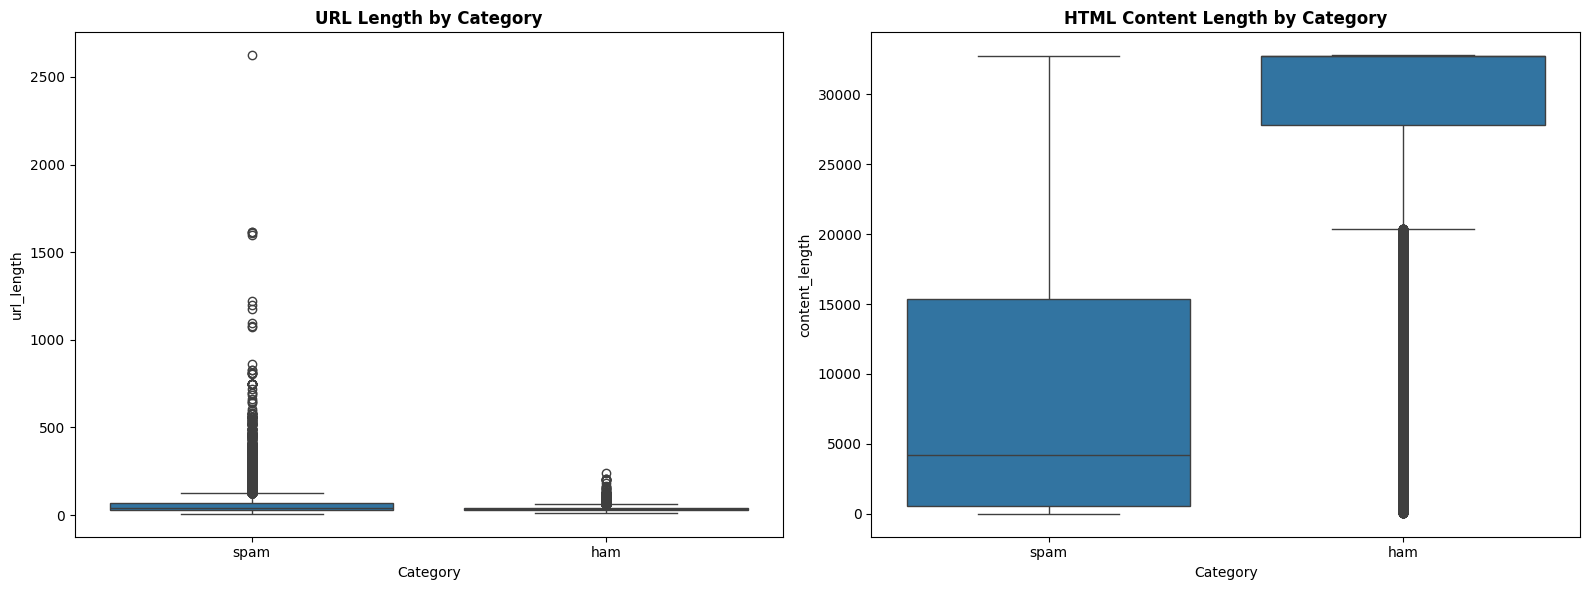

In [10]:
# URL Length Analysis
url_df['url_length'] = url_df['Data'].apply(len)

# HTML Content Length Analysis
html_df['content_length'] = html_df['Data'].apply(len)

plt.figure(figsize=(16, 6))

# URL Length Analysis
plt.subplot(1, 2, 1)
sns.boxplot(x='Category', y='url_length', data=url_df)
plt.title('URL Length by Category', fontweight="bold")

# HTML Content Length Analysis
plt.subplot(1, 2, 2)
sns.boxplot(x='Category', y='content_length', data=html_df)
plt.title('HTML Content Length by Category', fontweight="bold")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Berdasarkan pola yang diamati pada dataset, kategori **phishing (spam) **cenderung memiliki karakter yang panjang, sementara kategori **non-phishing (ham)** cenderung memiliki karakter yang pendek.

# text preprocessing
## inisialisasi kebutuhan

In [11]:
# Ensure necessary NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
# Load stopwords once to improve efficiency
STOPWORDS = set(stopwords.words('english'))

In [13]:
# Initialize WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# fungsi preprocessing

In [14]:
# Function to clean and preprocess URL data
def preprocess_url(url):
    url = url.lower()  # Convert to lowercase
    url = re.sub(r'https?://', '', url)  # Remove http or https
    url = re.sub(r'www\.', '', url)  # Remove www
    url = re.sub(r'[^a-zA-Z0-9]', ' ', url)  # Remove special characters
    url = re.sub(r'\s+', ' ', url).strip()  # Remove extra spaces
    tokens = word_tokenize(url)  # Tokenize
    tokens = [word for word in tokens if word not in STOPWORDS]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

In [15]:
# Function to clean and preprocess HTML data
def preprocess_html(html):
    html = re.sub(r'<[^>]+>', ' ', html)  # Remove HTML tags
    html = html.lower()  # Convert to lowercase
    html = re.sub(r'https?://', '', html)  # Remove http or https
    html = re.sub(r'[^a-zA-Z0-9]', ' ', html)  # Remove special characters
    html = re.sub(r'\s+', ' ', html).strip()  # Remove extra spaces
    tokens = word_tokenize(html)  # Tokenize
    tokens = [word for word in tokens if word not in STOPWORDS]  # Remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Lemmatization
    return ' '.join(tokens)

In [16]:
# Clean URL 'Data' Columns
url_df['cleaned_data'] = url_df['Data'].apply(preprocess_url)
url_df['cleaned_data'].head()

0    logtelstra2021 ddnsking com 0dfa1b53b835500696...
1    dvsber ru module mod ariimageslidersa krenk3n4...
2    kimsinc564 000webhostapp com notification php ...
3                                           benjim com
4                                micesrunescape com ru
Name: cleaned_data, dtype: object

In [17]:
# Clean HTML 'Data' Columns
html_df['cleaned_data'] = html_df['Data'].apply(preprocess_html)
html_df['cleaned_data'].head()

0    send money pay online set merchant account pay...
1    window wiz global data dpimgf false ep1ykd acc...
2    url error talktalk co uk main participantid nm...
3                                                     
4    sign microsoft online service ie legacy displa...
Name: cleaned_data, dtype: object

# Modeling
## tokenizaning

In [18]:
# Define the maximum length of sequences
max_url_length = 180
max_html_length = 2000

# Define the maximum number of words/tokens
max_words = 10000

In [19]:
# URL Tokenization and Padding
url_tokenizer = Tokenizer(num_words=max_words)
url_tokenizer.fit_on_texts(url_df['cleaned_data'])
url_sequences = url_tokenizer.texts_to_sequences(url_df['cleaned_data'])
url_padded = pad_sequences(url_sequences, maxlen=max_url_length,
                           padding='post', truncating='post')

# HTML Tokenization and Padding
html_tokenizer = Tokenizer(num_words=max_words)
html_tokenizer.fit_on_texts(html_df['cleaned_data'])
html_sequences = html_tokenizer.texts_to_sequences(html_df['cleaned_data'])
html_padded = pad_sequences(html_sequences, maxlen=max_html_length,
                            padding='post', truncating='post')

# label encoder

In [22]:
# Encode 'Category' column
label_encoder = LabelEncoder()
url_df['Category_Encoded'] = label_encoder.fit_transform(url_df['Category'])
html_df['Category_Encoded'] = label_encoder.transform(html_df['Category'])  # Ensure HTML uses the same encoding

# split dataset

In [23]:
# Split datasets into training and testing sets
url_X_train, url_X_test, url_y_train, url_y_test = train_test_split(url_padded, url_df['Category_Encoded'], test_size=0.2, random_state=42)
html_X_train, html_X_test, html_y_train, html_y_test = train_test_split(html_padded, html_df['Category_Encoded'], test_size=0.2, random_state=42)

# model arsitektur

In [24]:
def create_model():
    # Adjusted hyperparameters
    embedding_dim = 32 # Increased embedding dimension
    conv_filters = 128  # Increased number of filters in convolutional layers
    kernel_size = 10 # Increased kernel size
    dense_units_1 = 128
    dense_units_2 = 64
    learning_rate = 0.0001  # Adjusted learning rate

    # Model architecture
    url_input = layers.Input(shape=(max_url_length,), name='url_input')
    url_embedding = layers.Embedding(input_dim=min(max_words, len(url_tokenizer.word_index) + 1),
                                     output_dim=embedding_dim, input_length=max_url_length, name='url_embedding')(url_input)
    url_conv = layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(url_embedding)
    url_pool = layers.MaxPooling1D(pool_size=2)(url_conv)
    url_flat = layers.Flatten()(url_pool)

    html_input = layers.Input(shape=(max_html_length,), name='html_input')
    html_embedding = layers.Embedding(input_dim=min(max_words, len(html_tokenizer.word_index) + 1),
                                      output_dim=embedding_dim, input_length=max_html_length, name='html_embedding')(html_input)
    html_conv = layers.Conv1D(filters=conv_filters, kernel_size=kernel_size, activation='relu')(html_embedding)
    html_pool = layers.MaxPooling1D(pool_size=2)(html_conv)
    html_flat = layers.Flatten()(html_pool)

    concatenated = layers.Concatenate(name='concatenate_layer')([url_flat, html_flat])
    dense1 = layers.Dense(dense_units_1, activation='relu', name='dense1')(concatenated)
    dense2 = layers.Dense(dense_units_2, activation='relu', name='dense2')(dense1)
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(dense2)

    # Model compilation with directly imported metrics
    model = models.Model(inputs=[url_input, html_input], outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    return model

In [25]:
# Create the model
model = create_model()
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 url_input (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 html_input (InputLayer)     [(None, 2000)]               0         []                            
                                                                                                  
 url_embedding (Embedding)   (None, 180, 32)              320000    ['url_input[0][0]']           
                                                                                                  
 html_embedding (Embedding)  (None, 2000, 32)             320000    ['html_input[0][0]']          
                                                                                              

# train model

In [26]:
# Model Training
history = model.fit(
    [url_X_train, html_X_train],  # URL and HTML training data
    url_y_train,
    validation_data=([url_X_test, html_X_test], url_y_test),  # URL and HTML validation data
    epochs=10,  # Number of epochs to train for
    batch_size=8,  # Batch size for training
    #callbacks=[early_stopping]  # Early stopping callback
)

Epoch 1/10
4538/4538 [==============================] - 250s 53ms/step - loss: 0.1449 - accuracy: 0.9426 - precision: 0.9440 - recall: 0.9412 - val_loss: 0.0535 - val_accuracy: 0.9796 - val_precision: 0.9762 - val_recall: 0.9829
Epoch 2/10
4538/4538 [==============================] - 85s 19ms/step - loss: 0.0316 - accuracy: 0.9892 - precision: 0.9895 - recall: 0.9889 - val_loss: 0.0402 - val_accuracy: 0.9846 - val_precision: 0.9864 - val_recall: 0.9825
Epoch 3/10
4538/4538 [==============================] - 72s 16ms/step - loss: 0.0132 - accuracy: 0.9958 - precision: 0.9960 - recall: 0.9956 - val_loss: 0.0430 - val_accuracy: 0.9855 - val_precision: 0.9826 - val_recall: 0.9883
Epoch 4/10
4538/4538 [==============================] - 68s 15ms/step - loss: 0.0072 - accuracy: 0.9976 - precision: 0.9974 - recall: 0.9979 - val_loss: 0.0668 - val_accuracy: 0.9856 - val_precision: 0.9895 - val_recall: 0.9814
Epoch 5/10
4538/4538 [==============================] - 67s 15ms/step - loss: 0.0060 - 

# evaluasi

In [27]:
# Menyimpan riwayat pelatihan ke dalam DataFrame
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,precision,recall,val_loss,val_accuracy,val_precision,val_recall
0,0.144883,0.942614,0.943991,0.941238,0.053463,0.979614,0.976222,0.982931
1,0.031572,0.989173,0.989485,0.988886,0.040232,0.984573,0.986423,0.982487
2,0.013168,0.995785,0.995982,0.995598,0.043015,0.985455,0.982588,0.988251
3,0.007176,0.997631,0.997360,0.997909,0.066766,0.985565,0.989495,0.981379
4,0.006023,0.997989,0.997855,0.998129,0.055034,0.985455,0.984081,0.986699
5,0.004040,0.998733,0.998680,0.998790,0.056621,0.985124,0.980035,0.990246
6,0.002660,0.999256,0.999120,0.999395,0.068819,0.986336,0.982194,0.990468
7,0.002638,0.999256,0.999120,0.999395,0.079368,0.986005,0.988849,0.982931
8,0.003118,0.999036,0.998900,0.999175,0.086346,0.983691,0.979135,0.988251
9,0.002067,0.999339,0.999230,0.999450,0.092017,0.984463,0.980009,0.988916


In [28]:
# Model Evaluation
y_pred_prob = model.predict([url_X_test, html_X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

284/284 [==============================] - 2s 6ms/step


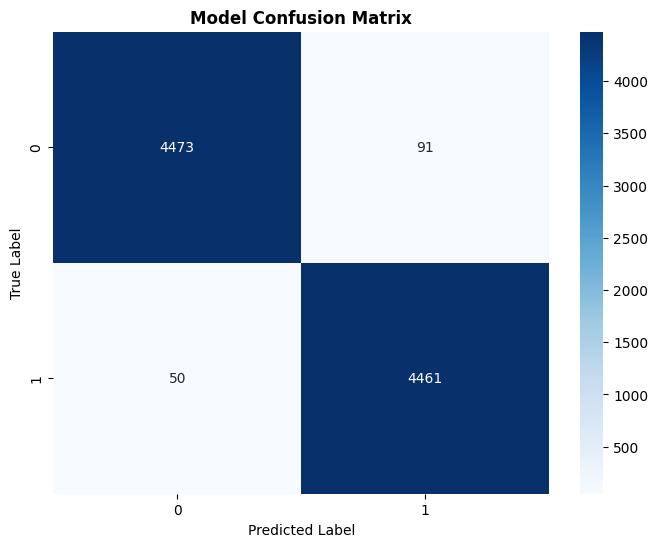

In [29]:
# Confusion Matrix
conf_matrix = confusion_matrix(url_y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Model Confusion Matrix", fontweight='bold')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [30]:
# Extracting values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Epochs range
epochs_range = range(1, len(training_loss) + 1)

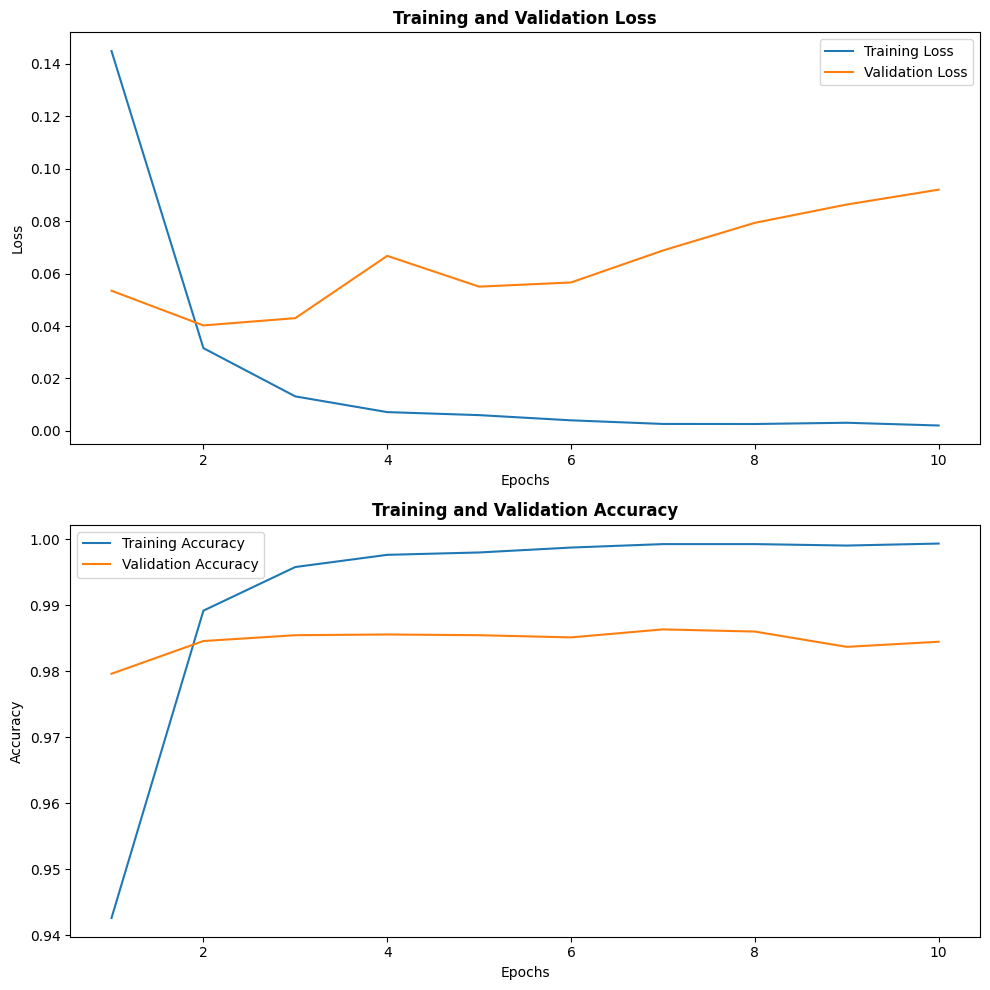

In [31]:
# Create subplots
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plotting Training and Validation Loss
axs[0].plot(epochs_range, training_loss, label='Training Loss')
axs[0].plot(epochs_range, validation_loss, label='Validation Loss')
axs[0].set_title('Training and Validation Loss', fontweight='bold')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plotting Training and Validation Accuracy
axs[1].plot(epochs_range, training_accuracy, label='Training Accuracy')
axs[1].plot(epochs_range, validation_accuracy, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy', fontweight='bold')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

# Save Model

In [46]:
# Define file path
model.save('/content/drive/MyDrive/phishing_detection_model.keras')

# Test Model

In [47]:
# Defining new benchmark data
new_urls = [
    "http://www.horadiadacompras.com/simples-login/entrar&amp;hnuhgjb",
    "https://portalnews.com/account/",
    "http://facebook-prize.com/offer/",
    "https://thediasuniversity.edu/our-achievements/",
    "http://paypal-secure-account.blogspot.com/"
]

new_htmls = [
    "<html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>",
    "<!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body></html>",
    "<html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></html>",
    "<!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements</body></html>",
    "<html><head><title>Your Account Has Been Suspended</title></head><body>Please log in to verify your account</body></html>"
]

actual_categories = ["spam", "ham", "spam", "ham", "spam"]  # Assuming the categories for the new benchmark data

# Preprocessing the new benchmark data
cleaned_urls = [preprocess_url(url) for url in new_urls]
cleaned_htmls = [preprocess_html(html) for html in new_htmls]

# Tokenizing and padding
new_url_sequences = url_tokenizer.texts_to_sequences(cleaned_urls)
new_url_padded = pad_sequences(new_url_sequences, maxlen=max_url_length, padding='post', truncating='post')

new_html_sequences = html_tokenizer.texts_to_sequences(cleaned_htmls)
new_html_padded = pad_sequences(new_html_sequences, maxlen=max_html_length, padding='post', truncating='post')

# Making predictions with the model
new_predictions_prob = model.predict([new_url_padded, new_html_padded])
new_predictions = (new_predictions_prob > 0.5).astype(int)  # Using 0.5 as the threshold for binary classification

# Displaying actual categories, predicted probabilities, and predicted categories
for i, (url, html) in enumerate(zip(new_urls, new_htmls)):
    actual_category = "Spam" if actual_categories[i] == "spam" else "Legitimate"
    predicted_category = "Spam" if new_predictions[i][0] == 1 else "Legitimate"
    print(f"URL: {url}")
    print(f"HTML Content: {html[:100]}...")  # Displaying a snippet for brevity
    print(f"Actual Category: {actual_category}")
    print(f"Predicted Probability: {new_predictions_prob[i][0]:.4f}")
    print(f"Predicted Category: {predicted_category}\n")

1/1 [==============================] - 0s 174ms/step
URL: http://www.horadiadacompras.com/simples-login/entrar&amp;hnuhgjb
HTML Content: <html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>...
Actual Category: Spam
Predicted Probability: 1.0000
Predicted Category: Spam

URL: https://portalnews.com/account/
HTML Content: <!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body><...
Actual Category: Legitimate
Predicted Probability: 0.9997
Predicted Category: Spam

URL: http://facebook-prize.com/offer/
HTML Content: <html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></h...
Actual Category: Spam
Predicted Probability: 1.0000
Predicted Category: Spam

URL: https://thediasuniversity.edu/our-achievements/
HTML Content: <!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements...
Actual Category: Legitimate
Predicted 

In [48]:
# Define new benchmark data
new_urls = [
"http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb",
"https://portalnews.com/account/",
"http://facebook-prize.com/offer/",
"https://thediasuniversity.edu/our-achievements/",
"http://paypal-secure-account.blogspot.com/",
"http://secure-login-paypal.com/",
"http://amazon-prime-offers.com/",
"https://secure-bankofamerica.com/login/",
"http://netflix-secure-login.com/",
"https://wellsfargo-secure.com/",
"https://stanford.edu/research/",
"http://gmail-security.com/",
"http://www.airbnb-login.com/",
"https://harvard.edu/admissions/",
"https://linkedin-security.com/",
"http://ebay-security.com/",
"https://paypal-security.com/",
"https://bankofamerica-secure.com/",
"http://www.microsoft-security.com/",
"https://apple-secure.com/"
]

new_htmls = [
"<html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>",
"<!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body></html>",
"<html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></html>",
"<!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements</body></html>",
"<html><head><title>Your Account Has Been Suspended</title></head><body>Please log in to verify your account</body></html>",
"<html><head><title>Secure Login</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Amazon Prime Offers</title></head><body>Click here to claim your Amazon Prime offers</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Bank of America login details</body></html>",
"<html><head><title>Netflix Login</title></head><body>Please enter your Netflix credentials</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Wells Fargo login details</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Stanford Research</title></head><body>Information about our research</body></html>",
"<html><head><title>Gmail Security</title></head><body>Please enter your Gmail credentials</body></html>",
"<html><head><title>Airbnb Login</title></head><body>Please enter your Airbnb credentials</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Harvard Admissions</title></head><body>Information about admissions</body></html>",
"<html><head><title>LinkedIn Security</title></head><body>Please enter your LinkedIn credentials</body></html>",
"<html><head><title>eBay Security</title></head><body>Please enter your eBay credentials</body></html>",
"<html><head><title>PayPal Security</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Bank of America Security</title></head><body>Please enter your Bank of America credentials</body></html>",
"<html><head><title>Microsoft Security</title></head><body>Please enter your Microsoft credentials</body></html>",
"<html><head><title>Apple Security</title></head><body>Please enter your Apple credentials</body></html>"
]

actual_categories = ["spam", "ham", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam", "ham", "spam", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam"]

# Preprocess the new benchmark data
cleaned_urls = [preprocess_url(url) for url in new_urls]
cleaned_htmls = [preprocess_html(html) for html in new_htmls]

# Tokenize and pad
new_url_sequences = url_tokenizer.texts_to_sequences(cleaned_urls)
new_url_padded = pad_sequences(new_url_sequences, maxlen=max_url_length, padding='post', truncating='post')

new_html_sequences = html_tokenizer.texts_to_sequences(cleaned_htmls)
new_html_padded = pad_sequences(new_html_sequences, maxlen=max_html_length, padding='post', truncating='post')

# Make predictions with the model
new_predictions_prob = model.predict([new_url_padded, new_html_padded])
new_predictions = (new_predictions_prob > 0.5).astype(int)

# Define the table
table = PrettyTable()
table.field_names = ["URL", "HTML Snippet", "Actual", "Predicted Probability", "Predicted Category"]

# Populate the table
for i, (url, html) in enumerate(zip(new_urls, new_htmls)):
    html_snippet = html[:100] + "..."  # Displaying a snippet for brevity
    actual_category = "Spam" if actual_categories[i] == "spam" else "Legitimate"
    predicted_category = "Spam" if new_predictions[i][0] == 1 else "Legitimate"
    table.add_row([url, html_snippet, actual_category, f"{new_predictions_prob[i][0]:.4f}", predicted_category])

# Print the table
print(table)

1/1 [==============================] - 0s 21ms/step
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
|                             URL                              |                                               HTML Snippet                                              |   Actual   | Predicted Probability | Predicted Category |
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
| http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb |  <html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>... |    Spam    |         1.0000        |        Spam        |
|               https://portalne

# Load The Saved Model and Try It

In [49]:
# Load trained model
model = keras.models.load_model('/content/drive/MyDrive/phishing_detection_model.keras')

In [50]:
# Define new benchmark data
new_urls = [
"http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb",
"https://portalnews.com/account/",
"http://facebook-prize.com/offer/",
"https://thediasuniversity.edu/our-achievements/",
"http://paypal-secure-account.blogspot.com/",
"http://secure-login-paypal.com/",
"http://amazon-prime-offers.com/",
"https://secure-bankofamerica.com/login/",
"http://netflix-secure-login.com/",
"https://wellsfargo-secure.com/",
"https://stanford.edu/research/",
"http://gmail-security.com/",
"http://www.airbnb-login.com/",
"https://harvard.edu/admissions/",
"https://linkedin-security.com/",
"http://ebay-security.com/",
"https://paypal-security.com/",
"https://bankofamerica-secure.com/",
"http://www.microsoft-security.com/",
"https://apple-secure.com/"
]

new_htmls = [
"<html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>",
"<!DOCTYPE html><html><head><title>News Update</title></head><body>Welcome to our news portal</body></html>",
"<html><head><script>var a=1; stealCredentials();</script></head><body>Login to see content</body></html>",
"<!DOCTYPE html><html lang=en><head><title>University of Thedias</title></head><body>Our Achievements</body></html>",
"<html><head><title>Your Account Has Been Suspended</title></head><body>Please log in to verify your account</body></html>",
"<html><head><title>Secure Login</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Amazon Prime Offers</title></head><body>Click here to claim your Amazon Prime offers</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Bank of America login details</body></html>",
"<html><head><title>Netflix Login</title></head><body>Please enter your Netflix credentials</body></html>",
"<html><head><title>Secure Login</title></head><body>Enter your Wells Fargo login details</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Stanford Research</title></head><body>Information about our research</body></html>",
"<html><head><title>Gmail Security</title></head><body>Please enter your Gmail credentials</body></html>",
"<html><head><title>Airbnb Login</title></head><body>Please enter your Airbnb credentials</body></html>",
"<!DOCTYPE html><html lang=en><head><title>Harvard Admissions</title></head><body>Information about admissions</body></html>",
"<html><head><title>LinkedIn Security</title></head><body>Please enter your LinkedIn credentials</body></html>",
"<html><head><title>eBay Security</title></head><body>Please enter your eBay credentials</body></html>",
"<html><head><title>PayPal Security</title></head><body>Please enter your PayPal credentials</body></html>",
"<html><head><title>Bank of America Security</title></head><body>Please enter your Bank of America credentials</body></html>",
"<html><head><title>Microsoft Security</title></head><body>Please enter your Microsoft credentials</body></html>",
"<html><head><title>Apple Security</title></head><body>Please enter your Apple credentials</body></html>"
]

actual_categories = ["spam", "ham", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam", "ham", "spam", "spam", "ham", "spam", "spam", "spam", "spam", "spam", "spam"]

# Preprocess the new benchmark data
cleaned_urls = [preprocess_url(url) for url in new_urls]
cleaned_htmls = [preprocess_html(html) for html in new_htmls]

# Tokenize and pad
new_url_sequences = url_tokenizer.texts_to_sequences(cleaned_urls)
new_url_padded = pad_sequences(new_url_sequences, maxlen=max_url_length, padding='post', truncating='post')

new_html_sequences = html_tokenizer.texts_to_sequences(cleaned_htmls)
new_html_padded = pad_sequences(new_html_sequences, maxlen=max_html_length, padding='post', truncating='post')

# Make predictions with the model
new_predictions_prob = model.predict([new_url_padded, new_html_padded])
new_predictions = (new_predictions_prob > 0.5).astype(int)

# Define the table
table = PrettyTable()
table.field_names = ["URL", "HTML Snippet", "Actual", "Predicted Probability", "Predicted Category"]

# Populate the table
for i, (url, html) in enumerate(zip(new_urls, new_htmls)):
    html_snippet = html[:100] + "..."  # Displaying a snippet for brevity
    actual_category = "Spam" if actual_categories[i] == "spam" else "Legitimate"
    predicted_category = "Spam" if new_predictions[i][0] == 1 else "Legitimate"
    table.add_row([url, html_snippet, actual_category, f"{new_predictions_prob[i][0]:.4f}", predicted_category])

# Print the table
print(table)

1/1 [==============================] - 0s 175ms/step
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
|                             URL                              |                                               HTML Snippet                                              |   Actual   | Predicted Probability | Predicted Category |
+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+------------+-----------------------+--------------------+
| http://www.horadiadacompras.com/simples-login/entrar&hnuhgjb |  <html><head><title>Free Offer</title></head><body>Click here to claim your free phone</body></html>... |    Spam    |         1.0000        |        Spam        |
|               https://portaln

# BELOW ARE EXPERIMENTS
## Experiment Model

In [51]:
def experiment_model():
    embedding_dim = 128  # Embedding dimension for both URL and HTML

    # URL Embedding Path
    url_input = layers.Input(shape=(max_url_length,), name='url_input')
    url_embedding = layers.Embedding(input_dim=min(max_words, len(url_tokenizer.word_index) + 1),
                                     output_dim=embedding_dim, input_length=max_url_length, name='url_embedding')(url_input)
    url_conv = layers.Conv1D(filters=64, kernel_size=8, activation='relu')(url_embedding)
    url_pool = layers.MaxPooling1D(pool_size=2)(url_conv)
    url_flat = layers.Flatten()(url_pool)

    # HTML Embedding Path
    html_input = layers.Input(shape=(max_html_length,), name='html_input')
    html_embedding = layers.Embedding(input_dim=min(max_words, len(html_tokenizer.word_index) + 1),
                                      output_dim=embedding_dim, input_length=max_html_length, name='html_embedding')(html_input)
    html_conv = layers.Conv1D(filters=64, kernel_size=8, activation='relu')(html_embedding)
    html_pool = layers.MaxPooling1D(pool_size=2)(html_conv)
    html_flat = layers.Flatten()(html_pool)

    # Concatenate Flat Outputs
    concatenated = layers.Concatenate(name='concatenate_layer')([url_flat, html_flat])

    # Fully Connected Layers
    dense1 = layers.Dense(128, activation='relu', name='dense1')(concatenated)
    dense2 = layers.Dense(64, activation='relu', name='dense2')(dense1)

    # Output Layer
    output = layers.Dense(1, activation='sigmoid', name='output_layer')(dense2)

    # Define the model using 'experiment_model' as the variable
    experiment_model = models.Model(inputs=[url_input, html_input], outputs=output)

    # Use 'experiment_model' for compilation
    experiment_model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                             loss='binary_crossentropy',
                             metrics=['accuracy', Precision(), Recall()])

    return experiment_model

In [52]:
# Create the adjusted model
experiment_model_instance = experiment_model()

In [53]:
# Model Summary
experiment_model_instance.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 url_input (InputLayer)      [(None, 180)]                0         []                            
                                                                                                  
 html_input (InputLayer)     [(None, 2000)]               0         []                            
                                                                                                  
 url_embedding (Embedding)   (None, 180, 128)             1280000   ['url_input[0][0]']           
                                                                                                  
 html_embedding (Embedding)  (None, 2000, 128)            1280000   ['html_input[0][0]']          
                                                                                            

# Experiment Model Training

In [54]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [55]:
# Model Training
history = experiment_model_instance.fit(
    [url_X_train, html_X_train],  # URL and HTML training data
    url_y_train,  # Assuming the same target variable for both URL and HTML
    validation_data=([url_X_test, html_X_test], url_y_test),  # URL and HTML validation data
    epochs=20,  # Number of epochs to train for
    batch_size=16,  # Batch size for training
    callbacks=[early_stopping]  # Early stopping callback
)

Epoch 1/20
2269/2269 [==============================] - 210s 91ms/step - loss: 0.0937 - accuracy: 0.9647 - precision_1: 0.9661 - recall_1: 0.9634 - val_loss: 0.0377 - val_accuracy: 0.9867 - val_precision_1: 0.9880 - val_recall_1: 0.9851
Epoch 2/20
2269/2269 [==============================] - 54s 24ms/step - loss: 0.0188 - accuracy: 0.9939 - precision_1: 0.9948 - recall_1: 0.9931 - val_loss: 0.0519 - val_accuracy: 0.9841 - val_precision_1: 0.9910 - val_recall_1: 0.9769
Epoch 3/20
2269/2269 [==============================] - 43s 19ms/step - loss: 0.0088 - accuracy: 0.9968 - precision_1: 0.9970 - recall_1: 0.9965 - val_loss: 0.0670 - val_accuracy: 0.9851 - val_precision_1: 0.9906 - val_recall_1: 0.9794
Epoch 4/20
2269/2269 [==============================] - 40s 17ms/step - loss: 0.0074 - accuracy: 0.9978 - precision_1: 0.9979 - recall_1: 0.9977 - val_loss: 0.0620 - val_accuracy: 0.9848 - val_precision_1: 0.9815 - val_recall_1: 0.9880


# Experiment Model Evaluation

In [56]:
# Model Evaluation
y_pred_prob = experiment_model_instance.predict([url_X_test, html_X_test])
y_pred = (y_pred_prob > 0.5).astype(int)

284/284 [==============================] - 2s 6ms/step


# Calculating Model Performance Based on Metrics

In [57]:
# Calculating metrics
accuracy = accuracy_score(url_y_test, y_pred)
precision = precision_score(url_y_test, y_pred)
recall = recall_score(url_y_test, y_pred)
f1 = f1_score(url_y_test, y_pred)

# Print Evaluation Metrics

In [58]:
# Printing evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9867
Precision: 0.9880
Recall: 0.9851
F1 Score: 0.9866
